# Logistic Regression From Scratch
In this notebook I will be implementing a logistic regression analysis for Kaggle's "Whale categorization playground" competition. This will be the first part in a multi-part
series in which I will use several different machine learning algorithms to perform categorization on the same dataset. In an effort to have a deeper understanding of each algorithm I will first be implementing them from scratch followed by using the Scikit-learn package.

When implementing this version of logistic regression I will be using a process adapted from a programming assignment I completed for Andrew Ng's fantastic coursera course "Neural Networks and Deep Learning".

In [26]:
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
import random
from tqdm import tnrange, tqdm_notebook

#### Split into training and cross validation sets

In [2]:
data_dir = 'C:/Users/efink/Documents/Github/whale-categorization/train/'

In [3]:
train_labels = pd.read_csv('train.csv')
train_labels.head()
train, cval = train_test_split(train_labels, test_size = 0.3, random_state = 42)

In [4]:
main_dir = %pwd
train_img_fns = glob.glob(main_dir + '/train/*')
n_train = train.shape[0]
n_train

6895

#### Create a batch generator for easy mini-batch learning later. Plot some example images

In [5]:
def process_batch(batch, data_direc):
    images = [Image.open(data_direc+image_fn).resize([256,128]) for image_fn in batch]
    images_rgb = [image.convert('RGB') if len(np.asarray(image).shape)<3 else image for image in images] ## converts grayscale images to RGB
    images_arr = np.array([np.asarray(image)/256 for image in images_rgb])
    flat_images = images_arr.reshape(images_arr.shape[0], -1).T
    return flat_images

In [6]:
def batch_gen(x_train, y_train, data_direc, batch_size = 16, process = True):
    n = 0
    while n < len(x_train):
        batch_x = x_train.iloc[n:n+batch_size]
        batch_y = y_train.iloc[n:n+batch_size]
        if process:
            batch_x = process_batch(batch_x, data_direc)
        yield batch_x, batch_y
        n = n + batch_size

In [7]:
def plot_imgs(img_fns, data_direc, dims, figsize = [16,8]):
    imgs = [np.asarray(Image.open(data_direc+img_fns.iloc[i])) for i in range(len(img_fns))]
    fig=plt.figure(figsize=figsize)
    columns = dims[1]
    rows = dims[0]
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])

In [8]:
plot_batches = batch_gen(train['Image'], train['Id'], data_dir, process = False)

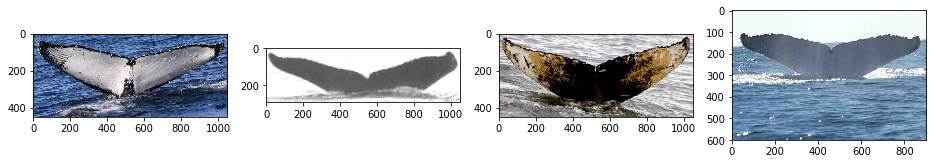

In [9]:
plot_batch, names = next(plot_batches)
plot_imgs(plot_batch.iloc[0:5], data_dir, [1,4])

#### Since there are multiple classes for this dataset I will need to implement 'one vs all' classification. According to kaggle the most challenging part of this competition is that there is a very limited number of examples (max 34) for each whale species (over 4000). This will likely result in very poor performance for logistic regression: 

In [10]:
batch_size = 64

In [11]:
batches = batch_gen(train['Image'],train['Id'], data_dir, batch_size = batch_size)

In [12]:
batch, batch_names = next(batches)

In [13]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(train_labels['Id'].as_matrix()) 
Y = lb.transform(batch_names)

In [14]:
Y.shape

(64, 4251)

In [15]:
def init_parameters(x_size, n_classes):
    W = np.zeros([x_size,n_classes]) #np.random.randn(x_size,1)
    B = 0
    return [B,W]

In [16]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [30]:
def fit_model(x_train, y_train, classes, epochs, learn_rate, data_dir, batch_size = 64):
    
    batches = batch_gen(x_train, y_train, data_dir, batch_size = batch_size)
    batch, _ = next(batches)
    x_size = batch.shape[0]
    
    lb = LabelBinarizer()
    lb.fit(classes) 
        
    B, W= init_parameters(x_size, len(classes))
    cost = []
    
    n = 0
    for ep in tnrange(epochs):
        print('epoch: ' + str(ep))
        for batch, batch_names in tqdm_notebook(batches):
            
            Y = lb.transform(batch_names)
            yhat = sigmoid(np.dot(W.T, batch) + B)
            
            cost.append((-1/batch.shape[1])*np.sum(np.add(np.multiply(Y.T, np.log(yhat)), np.multiply((1-Y.T), np.log(1-yhat)))))

            dz = (1/batch_size) * (yhat-Y.T)
            dW = np.dot(batch, dz.T)
            dB = np.sum(dz)

            W -= 0.01*dW
            B -= 0.01*dB
            n += 1
            
            if n % 25 == 0:
                print('iter ' + str(n) + ': mean cost = ' + str(np.mean(cost[-25:]))
                
        batches = batch_gen(x_train, y_train, data_dir, batch_size = batch_size)

    return {'W': W, 'B': B, 'cost':cost}


In [31]:
params = fit_model(train['Image'], train['Id'], train_labels['Id'].unique(), 3, 0.01, data_dir, batch_size = 80)

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

epoch: 0


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

iter 25: cost = 178.57975940000307
iter 50: cost = 182.93424969221033
iter 75: cost = 169.94153058479424
epoch: 1


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

iter 100: cost = 183.82198616617328
iter 125: cost = 160.59872132605184
iter 150: cost = 171.0170234982438
epoch: 2


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

iter 175: cost = 154.87783514729395
iter 200: cost = 163.35893420467673
iter 225: cost = 152.41403671148427
iter 250: cost = 149.94896450286913



Text(0.5,0,'log loss')

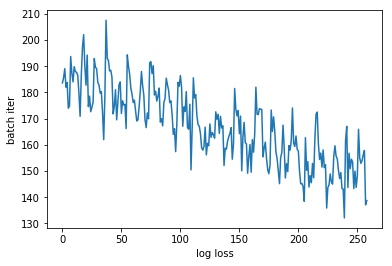

In [38]:
fig, ax = plt.subplots()
ax.plot(params['cost'][1:])
ax.set_ylabel('batch iter')
ax.set_xlabel('log loss')

In [59]:
class logistic_model_scratch:
    
    def __init__(self, train_x, train_y, classes, data_dir, batch_size = 64):
        
        self.train_x = train_x
        self.train_y = train_y
        self.classes = classes
        self.data_dir = data_dir
        self.batch_size = 64
        
        batches = batch_gen(train_x, train_y, data_dir, batch_size=1)
        batch, _ = next(batches)
        
        self.x_size = batch.shape[0]
        self.B, self.W = self.init_parameters()


    def init_parameters(self):
        self.W = np.zeros([self.x_size, len(self.classes)]) #np.random.randn(x_size,1)
        self.B = 0
        return self.B, self.W
    
    def forward_prop(self, W, B, batch):
        return sigmoid(np.dot(W.T, batch) + B)
    
    def back_prop(self, yhat, Y, batch):
        dz = (1/self.batch_size) * (yhat-Y.T)
        dW = np.dot(batch, dz.T)
        dB = np.sum(dz)
        W -= 0.01*dW
        B -= 0.01*dB
        return W, B

        
    def fit(self, epochs, learn_rate, batch_size = 64):
        
        batches = batch_gen(self.train_x, self.train_y, self.data_dir, batch_size = batch_size)
        batch, _ = next(batches)

        lb = LabelBinarizer()
        lb.fit(self.classes) 

        self.cost = []
        
        n = 0
        for ep in tnrange(epochs):
            print('epoch: ' + str(ep))
            for batch, batch_names in tqdm_notebook(batches):

                Y = lb.transform(batch_names)
                yhat = forward_prop(self.W, self.B, batch)

                cost.append((-1/batch.shape[1])*np.sum(np.add(np.multiply(Y.T, np.log(yhat)), np.multiply((1-Y.T), np.log(1-yhat)))))
                back_prop(yhat, Y, batch)
                
                n += 1
                if n % 25 == 0:
                    print('iter ' + str(n) + ': mean cost = ' + str(np.mean(cost[-25:]))

            batches = batch_gen(x_train, y_train, data_dir, batch_size = batch_size)
    

In [60]:
model = logistic_model_scratch(train['Image'], train['Id'], train_labels['Id'].unique(), data_dir)
model.fit(1, 0.01)
model.W

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
n_classes = len(train_labels['Id'].unique())
B, W= init_parameters(batch.shape[0], n_classes)
yhat = sigmoid(np.dot(W.T, batch) + B)

In [ ]:
(-1/batch_size)*np.add(np.log(yhat), np.multiply((1-Y.T), np.log(1-yhat)))

In [ ]:
learn_rate = 0.01

In [ ]:
dz = (1/batch_size) * (yhat-Y.T)
dW = np.dot(batch, dz.T)
dB = np.sum(dz)

W -= 0.01*dW
B -= 0.01*dB

In [ ]:
W.shape

In [ ]:
batches

In [ ]:
100%10

In [ ]:
10%100

In [ ]:
4%2

In [ ]:
200%10